In [169]:
%matplotlib inline
import os
import random
import time

import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [170]:
# Ensure deterministic behavior
def init_seeds(seed=0):
    torch.manual_seed(seed) # sets the seed for generating random numbers.
    torch.backends.cudnn.deterministic = True

init_seeds(1)
# Device configuration
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 0 NVIDIA GeForce RTX 3060 Laptop GPU


In [171]:
import wandb

wandb.login()
os.environ["WANDB_API_KEY"] = "x"*40

config = dict(
    epochs          = 20,
    batch_size      = 100,
    test_batch_size = 1000,
    learning_rate   = 0.007,
    classes         = 10,
    gamma           = 0.9,
    dataset         = "Kmnist",
    model           = "CNN",
    activation      = "relu",     # leaky relu/sigmoid/elu/tanh/relu
    optimizer       = "Adam",
    scheduler       = "ExponentialLR",
    kernel_size     = 3,
    padding         = 1,
    conv_block_1    = 64,
    conv_block_2    = 128,
    conv_block_3    = 256,
    conv_block_4    = 256,
)

wandb_init = dict(
#     job_type: Optional[str] = None,
#     dir = None,
    config = config,
    project = "Deep_Learning_HW1_Kuzushiji-MNIST",
#     entity = None,
#     reinit = None,
    # tags = ['wgan_gp_1v1'],
#     group = None,
    name = None,
    notes = None,
#     magic = None,
#     config_exclude_keys = None,
#     config_include_keys = None,
#     anonymous = None,
    mode = "disabled",  # "online","offline","disabled"
#     allow_val_change = None,
#     resume = None,
#     force = None,
#     tensorboard = None,
#     sync_tensorboard = None,
#     monitor_gym = None,
    save_code = True,
#     settings=None
)
class_names = (u'\u304A', u'\u304D', u'\u3059', u'\u3064', u'\u306A', u'\u306F', u'\u307E', u'\u3084', u'\u308C', u'\u3092')
class_names_eng = ('o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo')

In [172]:
import matplotlib.pyplot as plt

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    figure_array = np.transpose(npimg, (1, 2, 0))
    fig_o, ax_o = plt.subplots()
    ax_o.imshow(np.clip(figure_array, 0, 1))
    ax_o.get_xaxis().set_visible(False)
    ax_o.get_yaxis().set_visible(False)
    plt.show()


def output_loader_images(loader):
    dataiter = iter(loader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images[:4]))
    print('labels: ', ' '.join('%5s' % class_names_eng[labels[j]] for j in range(4)))
    return images, labels

In [173]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [174]:
import math

class Net(nn.Module):
    def two_conv(self, input_ch, output_ch_1, output_ch_2):
        seq = nn.Sequential(
            nn.Conv2d(input_ch, output_ch_1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_ch_1),
            nn.ReLU(),
            nn.Conv2d(output_ch_1, output_ch_2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_ch_2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        for mod in seq.children():
            if isinstance(mod, nn.Conv2d):
                n = mod.kernel_size[0] * mod.kernel_size[1] * mod.out_channels
                mod.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(mod, nn.BatchNorm2d):
                mod.weight.data.fill_(1)
                mod.bias.data.zero_()
        return seq
    def three_conv(self,input_ch, output_ch_1, output_ch_2, output_ch_3):
        seq = nn.Sequential(
            nn.Conv2d(input_ch, output_ch_1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_ch_1),
            nn.ReLU(),
            nn.Conv2d(output_ch_1, output_ch_2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_ch_2),
            nn.ReLU(),
            nn.Conv2d(output_ch_2, output_ch_3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_ch_3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        for m in seq.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        return seq
        
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = self.two_conv(1, 64, 64)
        self.layer2 = self.two_conv(64, 128, 128)
        self.layer3 = self.three_conv(128, 256, 256, 256)
        self.layer4 = self.three_conv(256, 256, 256, 256)
        
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 10),
        )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

In [175]:
import torch.optim as optim

def make(config):
    train_kwargs = {'batch_size': config["batch_size"],
                    'num_workers': 4,
                    'pin_memory': True,
                    'shuffle': True}
    test_kwargs  = {'batch_size': config["test_batch_size"],
                    'num_workers': 4,
                    'pin_memory': True,
                    'shuffle': True}

    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))])

    trainset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, **train_kwargs)
    
    testset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, **test_kwargs)

    

    # Make the model
    model = Net().to(device)

    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=config["gamma"])
    
    return model, criterion, optimizer, scheduler, trainloader, testloader

In [176]:
def test(model, test_loader, criterion):
    model.eval()

    correct, total, test_loss = 0, 0, 0
    with torch.no_grad():
        for i,data in enumerate(test_loader):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            test_loss += criterion(outputs, labels).item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()

            if i == len(test_loader) - 1:
                imshow(torchvision.utils.make_grid(images[:4].cpu()))
                print('labels: ', ' '.join('%5s' % class_names_eng[labels[j]] for j in range(4)))

        test_loss /= len(test_loader)
        test_accuracy = 100. * correct / len(test_loader.dataset)
        print('\nTest set:')
        print('Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))

In [177]:
def train(model, device, optimizer, criterion, scheduler, config, train_loader, test_loader):
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)

    start_time = time.time()
    running_loss_avg = AverageMeter()
    running_loss = 0
    running_loss_list = []
    for epoch in range(config["epochs"]):
        for i, data in enumerate(train_loader, 0):
            
            # get the inputs
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            running_loss += loss
            loss.backward()
            optimizer.step()

            running_loss_avg.update(loss.cpu(), labels.size(0))

            print(f"\rEpoch:{epoch+1:2d}  [{i+1:03}/{len(train_loader)} ({(i+1)/len(train_loader)*100:2.0f}%)], loss:{running_loss_avg.avg:.3f}, lr:{scheduler.get_last_lr()[0]:1.10f}", end='')
        print("\n")
        scheduler.step()
        running_loss /= len(train_loader)
        running_loss_list.append(running_loss.item())
    finished_training_time = time.time()-start_time
    print(f"\nFinished Training for {finished_training_time:.2f} s")
    fig, ax = plt.subplots()
    ax.plot(running_loss_list, 'b')
    ax.set_title("Average Training Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_xticks([0,3,6,9,12,15,18,21])

## Main

Epoch: 1  [600/600 (100%)], loss:0.392, lr:0.0070000000

Epoch: 2  [600/600 (100%)], loss:0.238, lr:0.0063000000

Epoch: 3  [600/600 (100%)], loss:0.178, lr:0.0056700000

Epoch: 4  [600/600 (100%)], loss:0.144, lr:0.0051030000

Epoch: 5  [600/600 (100%)], loss:0.122, lr:0.0045927000

Epoch: 6  [600/600 (100%)], loss:0.106, lr:0.0041334300

Epoch: 7  [600/600 (100%)], loss:0.094, lr:0.0037200870

Epoch: 8  [600/600 (100%)], loss:0.084, lr:0.0033480783

Epoch: 9  [600/600 (100%)], loss:0.076, lr:0.0030132705

Epoch:10  [600/600 (100%)], loss:0.070, lr:0.0027119434

Epoch:11  [600/600 (100%)], loss:0.064, lr:0.0024407491

Epoch:12  [600/600 (100%)], loss:0.059, lr:0.0021966742

Epoch:13  [600/600 (100%)], loss:0.055, lr:0.0019770068

Epoch:14  [600/600 (100%)], loss:0.052, lr:0.0017793061

Epoch:15  [600/600 (100%)], loss:0.049, lr:0.0016013755

Epoch:16  [600/600 (100%)], loss:0.046, lr:0.0014412379

Epoch:17  [600/600 (100%)], loss:0.043, lr:0.0012971141

Epoch:18  [600/600 (100%)], los

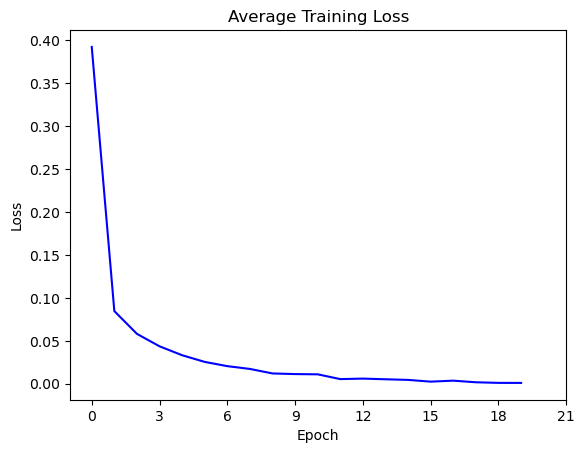

In [178]:
# tell wandb to get started
run = wandb.init(**wandb_init)

# make the model, data, and optimization problem
model, criterion, optimizer, scheduler, trainloader, testloader = make(config)

# and use them to train the model
train(model, device, optimizer, criterion, scheduler, config, trainloader, testloader)

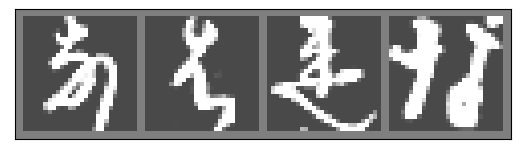

labels:     na    ha    re    na

Test set:
Average loss: 0.1333, Accuracy: 9814/10000 (98.14%)



In [179]:
# and test its final performance
test(model, testloader, criterion)

## Display the confusion matrix as a heatmap

In [180]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
preds = np.zeros((1))
truth = np.zeros((1))

model.eval()
with torch.no_grad():
    for i, data in enumerate(testloader):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images.to(device))
        pred = outputs.argmax(dim=1)
        c = pred.eq(labels.view_as(pred)).squeeze()
        preds = np.concatenate([preds, pred.cpu().numpy()], axis=0)
        truth = np.concatenate([truth, labels.cpu().numpy()], axis=0)

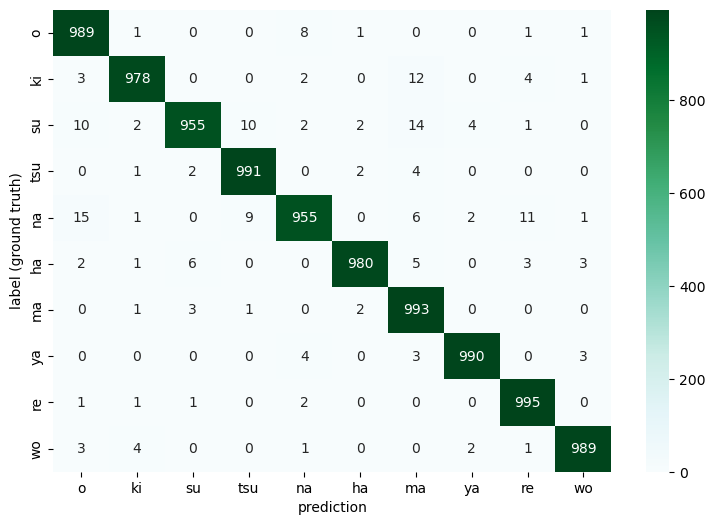

In [181]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import PIL.Image as Image
import io
# Display the confusion matrix as a heatmap
arr = confusion_matrix(truth, preds)
df_cm = pd.DataFrame(arr, class_names_eng, class_names_eng)
fig = plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")

img_buf = io.BytesIO()
plt.savefig(img_buf, format = "png")
im = Image.open(img_buf)
wandb.log({"figure": wandb.Image(im, caption="heatmap")})
img_buf.close()


## Some multi-class performance report defined from Scikit-learn

In [182]:
from sklearn.metrics import classification_report
print(classification_report(truth, preds, target_names=class_names))

              precision    recall  f1-score   support

           お       0.97      0.99      0.98      1001
           き       0.99      0.98      0.98      1000
           す       0.99      0.95      0.97      1000
           つ       0.98      0.99      0.99      1000
           な       0.98      0.95      0.97      1000
           は       0.99      0.98      0.99      1000
           ま       0.96      0.99      0.97      1000
           や       0.99      0.99      0.99      1000
           れ       0.98      0.99      0.99      1000
           を       0.99      0.99      0.99      1000

    accuracy                           0.98     10001
   macro avg       0.98      0.98      0.98     10001
weighted avg       0.98      0.98      0.98     10001



In [183]:
run.finish()